<div style="float:left">
    <h1 style="width:450px">Practical 9: Grouping Data</h1>
    <h2 style="width:450px">Aggregation, Classification &amp; Clustering</h2>
</div>
<div style="float:right"><img width="100" src="https://github.com/jreades/i2p/raw/master/img/casa_logo.jpg" /></div>

A common challenge in data analysis is how to group observations in a data set together in a way that allows for generalisation: _this_ group of observations are similar to one another, _that_ group is dissimilar to this group. Sometimes we have a *label* that we can use as part of the process (in which case we're doing **classification**), and somtimes we don't (in which case we're doing **clustering**). But what defines similarity and difference? There is no _one_ answer to that question and so there are many different ways to cluster or classify data, each of which has strengths and weaknesses that make them more, or less, appropriate in different contexts.

## Preamble

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
import re
import os

from matplotlib.colors import ListedColormap

# All of these are potentially useful, though
# not all have been used in this practical --
# I'd suggest exploring the use of different 
# Scalers/Transformers as well as clustering 
# algorithms...
import sklearn
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, PowerTransformer
from sklearn.cluster import KMeans, DBSCAN, OPTICS
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import silhouette_samples, silhouette_score

import random
random.seed(42)    # For reproducibility
np.random.seed(42) # For reproducibility

# Make numeric display a bit neater
pd.set_option('display.float_format', lambda x: '{:,.2f}'.format(x))

### Initialise the Scaler(s)

In [2]:
mms  = MinMaxScaler(feature_range=(-1,1))
stds = StandardScaler()
rbs  = RobustScaler()
pts  = PowerTransformer()

### Set Up Plotting Functions

In [3]:
def plt_ldn(w, b):
    """
    Creates a new figure of a standard size with the 
    water (w) and boundary (b) layers set up for easy
    plotting. Right now this function assumes that you're
    looking at London, but you could parameterise it in
    other ways ot allow it to work for other areas.
    
    w: a water layer for London
    b: a borough (or other) boundary layer for London
    """
    fig, ax = plt.subplots(1, figsize=(14, 12))
    w.plot(ax=ax, color='#79aef5', zorder=2)
    b.plot(ax=ax, edgecolor='#cc2d2d', facecolor='None', zorder=3)
    ax.set_xlim([502000,563000])
    ax.set_ylim([155000,201500])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    return fig, ax

########################
# These may no longer be relevant because of changes to geopandas API

def default_cmap(n, outliers=False):
    cmap = mpl.cm.get_cmap('viridis_r', n)
    colors = cmap(np.linspace(0,1,n))
    if outliers:
        gray = np.array([225/256, 225/256, 225/256, 1])
        colors = np.insert(colors, 0, gray, axis=0)
    return ListedColormap(colors)

# mappable = ax.collections[-1] if you add the geopandas
# plot last.
def add_colorbar(mappable, ax, cmap, norm, breaks, outliers=False):
    cb = fig.colorbar(mappable, ax=ax, cmap=cmap, norm=norm,
                    boundaries=breaks,
                    extend=('min' if outliers else 'neither'), 
                    spacing='uniform',
                    orientation='horizontal',
                    fraction=0.05, shrink=0.5, pad=0.05)
    cb.set_label("Cluster Number")

### Set up Caching Function

In [4]:
import os
from requests import get
from urllib.parse import urlparse

def cache_data(src:str, dest:str) -> str:
    """Downloads and caches a remote file locally.
    
    The function sits between the 'read' step of a pandas or geopandas
    data frame and downloading the file from a remote location. The idea
    is that it will save it locally so that you don't need to remember to
    do so yourself. Subsequent re-reads of the file will return instantly
    rather than downloading the entire file for a second or n-th itme.
    
    Parameters
    ----------
    src : str
        The remote *source* for the file, any valid URL should work.
    dest : str
        The *destination* location to save the downloaded file.
        
    Returns
    -------
    str
        A string representing the local location of the file.
    """
    
    url = urlparse(src) # We assume that this is some kind of valid URL 
    fn  = os.path.split(url.path)[-1] # Extract the filename
    dfn = os.path.join(dest,fn) # Destination filename
    
    # Check if dest+filename does *not* exist -- 
    # that would mean we have to download it!
    if not os.path.isfile(dfn) or os.path.getsize(dfn) < 1:
        
        print(f"{dfn} not found, downloading!")

        # Convert the path back into a list (without)
        # the filename -- we need to check that directories
        # exist first.
        path = os.path.split(dest)
        
        # Create any missing directories in dest(ination) path
        # -- os.path.join is the reverse of split (as you saw above)
        # but it doesn't work with lists... so I had to google how
        # to use the 'splat' operator! os.makedirs creates missing
        # directories in a path automatically.
        if len(path) >= 1 and path[0] != '':
            os.makedirs(os.path.join(*path), exist_ok=True)
            
        # Download and write the file
        with open(dfn, "wb") as file:
            response = get(src)
            file.write(response.content)
            
        print('Done downloading...')

    else:
        print(f"Found {dfn} locally!")

    return dfn

## Task 1. Load Data

### Task 1.1: London Data Layers

<div class="alert alert-block alert-success">
    <b>Difficulty level</b>: Low.
</div>

In [5]:
spath = 'https://github.com/jreades/fsds/blob/master/data/src/' # source path
ddir  = os.path.join('data','geo') # destination directory
water = gpd.read_file( cache_data(spath+'Water.gpkg?raw=true', ddir) )
boros = gpd.read_file( cache_data(spath+'Boroughs.gpkg?raw=true', ddir) )
green = gpd.read_file( cache_data(spath+'Greenspace.gpkg?raw=true', ddir) )

msoas = gpd.read_file( cache_data('http://orca.casa.ucl.ac.uk/~jreades/data/MSOA-2011.gpkg', ddir) )
msoas = msoas.to_crs(epsg=27700)

# I don't use this in this practical, but it's a
# really useful data set that gives you 'names'
# for MSOAs that broadly correspond to what most
# Londoners would think of as a 'neighbourhood'.
msoa_nms = gpd.read_file( cache_data('http://orca.casa.ucl.ac.uk/~jreades/data/MSOA-2011-Names.gpkg', ddir) )
msoa_nms = msoa_nms.to_crs(epsg=27700)
print("Done.")

Found data/geo/Water.gpkg locally!
Found data/geo/Boroughs.gpkg locally!
Found data/geo/Greenspace.gpkg locally!
Found data/geo/MSOA-2011.gpkg locally!
Found data/geo/MSOA-2011-Names.gpkg locally!
Done.


### Task 1.2: Reduced Dimensionality MSOA Data

<div class="alert alert-block alert-success">
    <b>Difficulty level</b>: Low.
</div>

You should have this locally from last week, but just in case...

In [6]:
host = 'http://orca.casa.ucl.ac.uk'
path = '~jreades/data'
rddf = gpd.read_feather( cache_data(f'{host}/{path}/Reduced_Dimension_Data.geofeather', ddir) )
print(f"Data frame is {rddf.shape[0]:,} x {rddf.shape[1]}")

Found data/geo/Reduced_Dimension_Data.geofeather locally!
Data frame is 983 x 93


You should have: `Data frame is 983 x 93`.

And below you should see both the components and the dimensions from last week's processing.

In [7]:
rddf.iloc[0:3, -7:]

,Component 5,Component 6,Component 7,Borough,Dimension 1,Dimension 2,Subregion
E02000001,1.44,3.95,-1.52,City of London,7.63,2.20,Inner West
E02000002,-0.28,0.89,0.26,Barking and Dagenham,2.59,7.01,Outer East and North East
E02000003,-0.11,1.12,0.83,Barking and Dagenham,3.39,6.12,Outer East and North East


I get:

|        | Component 5 | Component 6 | Component 7 | Borough | Dimension 1 | Dimension 2 | Subregion |
| :------| ----------: | -----------:| ----------: | ------: | ----------: | ----------: | --------: |
| **E02000001** | 1.44 | 3.95 | -1.52 | City of London | 7.63 | 2.20 | Inner West |
| **E02000002** | -0.28 | 0.89 | 0.26 | Barking and Dagenham | 2.59 | 7.01 | Outer East and North East |
| **E02000003** | -0.11 | 1.12 | 0.83 | Barking and Dagenham | 3.39 | 6.12 | Outer East and North East |

### Task 1.3: Listings Data

<div class="alert alert-block alert-success">
    <b>Difficulty level</b>: Low.
</div>

Let's also get the listings data from a few weeks back:

In [8]:
listings = gpd.read_feather( cache_data(f'{host}/{path}/2022-09-10-listings.geofeather', ddir) )
listings = listings.to_crs(epsg=27700)
listings = listings.drop(columns=['index']).set_index('id')
print(f"Data frame is {listings.shape[0]:,} x {listings.shape[1]}")

Found data/geo/2022-09-10-listings.geofeather locally!
Data frame is 68,741 x 31


You should have: `Data frame is 68,741 x 31`.

And a quick plot of the price to check:

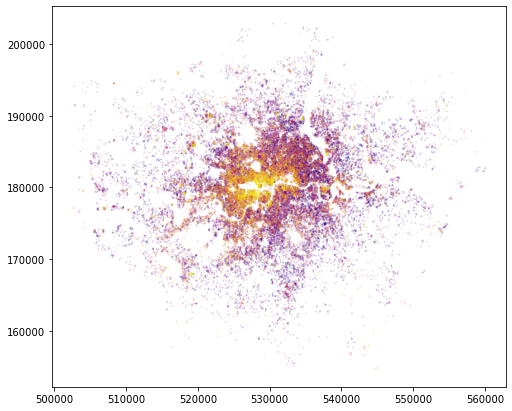

In [9]:
listings.plot(column='price', cmap='plasma', scheme='quantiles', k=10, 
              markersize=.5, alpha=0.15, figsize=(10,7));

## Task 2. Aggregate Listings by MSOA

### Task 2.1: Join Listings to MSOA

<div class="alert alert-block alert-warning">
    <b>Difficulty level</b>: Medium-to-hard.
</div>

First, let's link all this using the MSOA Geography that we created last week and a mix or merge and sjoin!

In [10]:
msoa_listings = gpd.sjoin(listings, msoas.drop(
                        columns=['MSOA11NM', 'LAD11CD', 'LAD11NM', 'RGN11CD', 'RGN11NM',
                                 'USUALRES', 'HHOLDRES', 'COMESTRES', 'POPDEN', 'HHOLDS', 
                                 'AVHHOLDSZ']), predicate='within').drop(
                        columns=['latitude','longitude','index_right']
                )

In [11]:
# All we've added is the MSOA11CD
msoa_listings.columns

Index(['listing_url', 'last_scraped', 'name', 'description', 'host_id',
       'host_name', 'host_since', 'host_location', 'host_is_superhost',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'property_type', 'room_type', 'accommodates',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'availability_365',
       'number_of_reviews', 'first_review', 'last_review',
       'review_scores_rating', 'reviews_per_month', 'geometry', 'MSOA11CD'],
      dtype='object')

All being well you should now have:

```
Index(['listing_url', 'last_scraped', 'name', 'description', 'host_id',
       'host_name', 'host_since', 'host_location', 'host_is_superhost',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'property_type', 'room_type', 'accommodates',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'availability_365',
       'number_of_reviews', 'first_review', 'last_review',
       'review_scores_rating', 'reviews_per_month', 'geometry', 'MSOA11CD'],
      dtype='object')
```

### Task 2.2: Price by MSOA 

<div class="alert alert-block alert-warning">
    <b>Difficulty level</b>: Medium.
</div>

Let's calculate the median price by MSOA... Notice that we have to specify the column we want after the `groupby` so the we don't get the median of *every* column returned

In [12]:
# *m*soa *l*istings *g*rouped *p*rice
mlgp = msoa_listings.groupby('MSOA11CD')['price'].agg('median') 
mlgp.head()

MSOA11CD
E02000001   196.00
E02000002    50.00
E02000003    72.00
E02000004    52.00
E02000005    82.00
Name: price, dtype: float64

You should get something like:

```
MSOA11CD
E02000001   196.00
E02000002    50.00
E02000003    72.00
E02000004    52.00
E02000005    82.00
Name: price, dtype: float64
```

### Task 2.3: Room Type by MSOA

<div class="alert alert-block alert-warning">
    <b>Difficulty level</b>: Medium.
</div>

Now let's calculate the count of room types by MSOA and compare the effects of `reset_index` on the outputs below. And notice too that we can assign the aggregated value to a column name!

In [13]:
# *m*soa *l*istings *g*rouped *c*ount
mlgc = msoa_listings.groupby(['MSOA11CD','room_type']).listing_url.agg(Count='count')
mlgc.head()

Count
MSOA11CD  room_type             
E02000001 Entire home/apt    365
          Hotel room           0
          Private room        50
          Shared room          1
E02000002 Entire home/apt      2

You should get something resembling this:

| MSOA11CD | room_type | Count<br/>&nbsp;<br />&nbsp; |
| -------: | :-------- | --: |
| **E02000001** | **Entire home/apt** | 365 |
|  | **Hotel room** | 0 |
|  | **Private room** | 50 |
|  | **Shared room** | 1 |
| **E02000002** | **Entire home/apt** | 2 |

In [14]:
# *m*soa *l*istings *g*rouped *c*ount *r*eset index
mlgcr = msoa_listings.groupby(['MSOA11CD','room_type']).listing_url.agg(Count='count').reset_index() # msoa listings grouped counts
mlgcr.head()

,MSOA11CD,room_type,Count
0,E02000001,Entire home/apt,365
1,E02000001,Hotel room,0
2,E02000001,Private room,50
3,E02000001,Shared room,1
4,E02000002,Entire home/apt,2


You should get something like: 

|    | MSOA11CD | room_type | Count |
| -: | :------- | :-------- | ----: |
| 0 | E02000001 | Entire home/apt | 365 |
| 1 | E02000001 | Hotel room | 0 |
| 2 | E02000001 | Private room | 50 |
| 3 | E02000001 | Shared room | 1 |
| 4 | E02000002 | Entire home/apt | 2 |

### Task 2.4: Price by Room Type

<div class="alert alert-block alert-danger">
    <b>Difficulty level</b>: Hard.
</div>

But perhaps median price/room type would make more sense? And do we want to retain values where there are no listings? For example, there are no hotel rooms listed for E02000001, how do we ensure that these *NAs are dropped*?

In [15]:
# *m*soa *l*istings *g*rouped *r*oom *p*rice
mlgrp = msoa_listings.groupby(  
                        ['MSOA11CD','room_type']
                      )['price'].agg('median').reset_index().dropna(axis=0)
mlgrp.head()

,MSOA11CD,room_type,price
0,E02000001,Entire home/apt,200.00
2,E02000001,Private room,67.00
3,E02000001,Shared room,120.00
4,E02000002,Entire home/apt,154.00
6,E02000002,Private room,50.00


You should get something like:

|    | MSOA11CD | room type | price |
| -: | :------- | :-------  | ----: |
| 0 | E02000001 | Entire home/apt | 200.00 |
| 2 | E02000001 | Private room | 67.00 |
| 3 | E02000001 | Shared room | 120.00 |
| 4 | E02000002 | Entire home/apt | 154.00 |
| 6 | E02000002 | Private room | 50.00 |

### Task 2.5: Explore Outlier Per-MSOA Prices

<div class="alert alert-block alert-warning">
    <b>Difficulty level</b>: Medium.
</div>

Are there MSOAs what *look* like they might contain erroneous data?

#### 2.5.1 Plot MSOA Median Prices

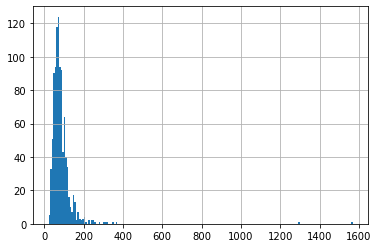

In [16]:
mlgp.hist(bins=200);

#### 2.5.2 Examine Listings from High-Priced MSOAs

Careful, this is showing the *listings* from MSOAs whose median price is above $300/night:

In [17]:
msoa_listings[
    msoa_listings.MSOA11CD.isin(mlgp[mlgp > 300].index)
].sort_values(by='price', ascending=False).head(7)[
    ['price','room_type','property_type','name','description']
]

,price,room_type,property_type,name,description
id,,,,,
39436239,"9,428.00",Entire home/apt,Entire serviced apartment,COMO Metropolitan Deluxe 2 Bdrm Brick St Resid...,Serviced two-bedroom luxury Residences with pr...
39436642,"9,428.00",Entire home/apt,Entire serviced apartment,"COMO Metropolitan, 2 Bedroom Metropolitan Duplex","Our ground-floor apartment, set across two flo..."
39436092,"9,428.00",Entire home/apt,Entire serviced apartment,"COMO Metropolitan, 2 Bedroom Brick St. Residence",Our new Brick Street Residences are sized from...
544024019639521536,"7,993.00",Entire home/apt,Entire home,Majestic Belgrave House next to Buckingham Pal...,"An elegant and spacious property, situated in ..."
48118935,"7,000.00",Entire home/apt,Entire home,Semi-detached mews house in Knightsbridge.,A bright and luxurious semi-detached mews hous...
38535683,"6,940.00",Entire home/apt,Entire home,Magnificent House in Knightsbridge,"Prince's Gate, on Exhibition Road, Approximate..."
704905955637359360,"6,500.00",Entire home/apt,Entire condo,Lovely 2 bedroom Condo in South Kensington,Beautifully presented 2 bedroom split level ap...


Those look fairly 'legit', but what about these:

In [18]:
msoa_listings[
    (msoa_listings.MSOA11CD.isin(mlgp[mlgp > 300].index)) & (msoa_listings.room_type!='Entire home/apt')
].sort_values(by='price', ascending=False).head(7)[
    ['price','room_type','property_type','name','description']
]

,price,room_type,property_type,name,description
id,,,,,
32205440,"2,999.00",Private room,Private room in townhouse,(A) Mayfair / Green Park,Historic Townhouse. A spacious 7 Bedroom split...
44351204,"2,444.00",Private room,Private room in rental unit,Central London room by Westminster Abbey,Not only the beautiful London stock brick faça...
32278025,"2,100.00",Private room,Private room in townhouse,Entire townhouse - PiccadillyCircus - StJames,A spectacular six floor historic London TownHo...
42940031,"1,880.00",Private room,Private room in rental unit,Chic Deluxe Room ❤ of Westminster☝10min→Buckin...,Not only the beautiful London stock brick faça...
661274993095249024,"1,675.00",Private room,Private room in hostel,✰✯✰Private room close to Surbiton train statio...,Located in a leafy green residential area in S...
653352778927156864,"1,675.00",Private room,Private room in hostel,✰✯✰Private room close to Surbiton train statio...,Located in a leafy green residential area in S...
653353251972118016,"1,675.00",Private room,Private room in hostel,✰✯✰Private room close to Surbiton train statio...,Located in a leafy green residential area in S...


Personally, I don't know that I'd pay $1,675 for a room *anywhere*, no matter how fancy, but if we wanted to be rigorous then we'd have to investigate further: perhaps that's *really* a price/month because the minimum stay is 30 days? And properties in Mayfair and Westminster *are* going to be expensive.

On the whole, let's take a *guess* that there are a small number of implausibly high prices for individual units that aren't in very expensive neighbourhoods (the multiple Surbiton listings, for example) and that these are either erroneous/deliberately incorrect, or represent a price that is not per-night. 

#### 2.5.3 Filter Unlikely Listings

<div class="alert alert-block alert-danger">
    <b>Difficulty level</b>: Hard.
</div>

See if you can filter out these less likely listings on the following criteria:

1. Listings are priced above $300/night AND
2. Room type is not `'Entire home/apt'` AND
3. Listings do *not* contain the words: suite, luxury, loft, stunning, prime, historic, or deluxe.

I found 901 rows to drop this way.

In [19]:
target_regex = r'(?:suite|luxury|loft|stunning|prime|historic|deluxe)'
to_drop = msoa_listings[
            (msoa_listings.price > 300) & 
            (msoa_listings.room_type != 'Entire home/apt') &
            ~(msoa_listings.name.str.contains(target_regex, flags=re.IGNORECASE, regex=True, na=True))]
print(f"Have found {to_drop.shape[0]:,} rows to drop on the basis of unlikely per night prices.")

Have found 901 rows to drop on the basis of unlikely per night prices.


In [20]:
to_drop.sort_values(by='price', ascending=False)[['price','room_type','name','description']]

,price,room_type,name,description
id,,,,
678185294323378048,"25,000.00",Private room,"Big Single Room Near Stratford, East London",A basic room - nothing special. But cheap & fr...
33472290,"23,000.00",Private room,"Budget single room near Stratford, East London",A basic room - nothing special. But cheap & fr...
44696103,"8,591.00",Private room,Cheap Single Rooms in Carlton Hotel,Cheap Single Room in Carlton Hotel<br />Carlto...
9470827,"8,000.00",Private room,"Room in a cosy flat. Central, clean","Centrally located, zone 2. Five minutes to tub..."
22965536,"8,000.00",Private room,Period Victorian house with garden,Beautiful Victorian house with ornate original...
...,...,...,...,...
40458121,303.00,Private room,Garden House in London,Beautiful cozy family house in a leafy area of...
45177260,302.00,Private room,Sonder Chelsea Green | Superior Double Room w/...,Boutique stores. Open-air bistros. Antique tre...
691043640095025920,302.00,Private room,Canalside Apartment Living- Kings Cross St Pan...,Family Apartment in Kings Cross St Pancras. En...


#### 2.5.4 Plot Unlikely Listings

Here we use the `plt_ldn` function -- notice how it's designed to return `f,ax` in the same way that `plt.subplots` (which we're already familiar with) does!

<AxesSubplot:>

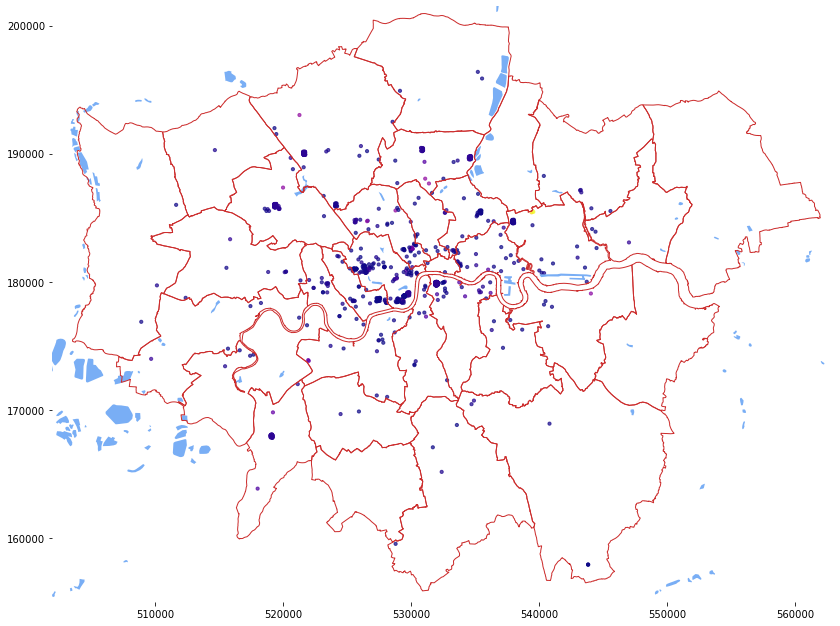

In [21]:
f,ax = plt_ldn(water, boros)
to_drop.plot(column='price', markersize=10, alpha=0.7, cmap='plasma', ax=ax)

#### 2.5.5 ... And Drop

The ones listed for the Carlton might be legitimate, but I'm feeling broadly ok with the remainder.

In [22]:
cleaned = msoa_listings.drop(index=to_drop.index)
print(f"Cleaned data has {cleaned.shape[0]:,} rows.")

Cleaned data has 67,087 rows.


After this I had 67,087 rows:

I would normally, at this point, spend quite a bit of time validating this cleaning approach, but right now we're going to take a rough-and-ready approach.

#### 2.5.6 Questions

- What data type did [Task 2.2](#Task-2.2:-Price-by-MSOA) return?

> A Series, note that the others returned data frames. It all depends on what you've asked for.

- What is the function of `reset_index()` in [Task 2.3](#Task-2.:3-Room-Type-by-MSOA) and when might you choose to reset (or not)?

> It removes any hierarchical indexing by row, unpacking the MSOA11CD -> Room Type hierarchy into a repeated MSOA11CD, Room Type pattern.


## Task 3. Pivot Tables & 'Wide Data'

The `group_by` operation is *one* way to organise and aggregate our data, but pivot tables are a *second* common way to achieve this. We typically use a pivot table to go from long to wide data frames -- it's often seen as one of Excel's main benefits, but Pandas can do that too!

### Task 3.1: Create Pivot Table

<div class="alert alert-block alert-danger">
    <b>Difficulty level</b>: Hard.
</div>

We can make use of the pivot table function to generate counts by MSOA in a 'wide' format.

In [23]:
pivot = cleaned.groupby(
                ['MSOA11CD','room_type']
        ).listing_url.agg(Count='count').reset_index().pivot(
                index='MSOA11CD', columns=['room_type'], values=['Count'])
pivot.head(3)

Count                                    
room_type Entire home/apt Hotel room Private room Shared room
MSOA11CD                                                     
E02000001             365          0           48           1
E02000002               2          0            6           0
E02000003               8          0           10           0

The formatting will look a tiny bit different, but you should get something like this: 

|    |          |       |       |       | Count |
| -: | -------: | ----: | ----: | ----: | ----: |
| **room_type** | **Entire home/apt** | **Hotel room** | **Private room** | **Shared room** |
| **MSOA11CD**. |  |  |  |  |  | 
| **E02000001** | 365 | 0 | 48 | 1 | 
| **E02000002** | 2 | 0 | 6 | 0 |
| **E02000003** | 8 | 0 | 10 | 0 |

### Task 3.2: Check Counts

<div class="alert alert-block alert-success">
    <b>Difficulty level</b>: Low.
</div>

In [24]:
pivot.sum()

       room_type      
Count  Entire home/apt    40515
       Hotel room           178
       Private room       26017
       Shared room          377
dtype: int64

In [25]:
print(cleaned[cleaned.room_type=='Entire home/apt'].listing_url.count())
print(cleaned[cleaned.room_type=='Private room'].listing_url.count())

40515
26017


### Task 3.3: Tidy & Normalise

<div class="alert alert-block alert-success">
    <b>Difficulty level</b>: Low.
</div>

My instinct at this point is that, looking at the pivot table, we see quite different levels of Airbnb penetration and it is hard to know how handle this difference: share would be unstable because of the low counts in some places and high counts in others; a derived variable that tells us something about density or mix could be interesting (e.g. HHI or LQ) but wouldn't quite capture the pattern of mixing.

#### 3.3.1 Tidy

Personally, based on the room type counts above I think we can drop Hotel Rooms and Shared Rooms from this since the other two categories are *so* dominant.

In [26]:
# Flatten the column index
pivot.columns = ['Entire home/apt','Hotel room','Private room','Shared room']
# Drop the columns
pivot.drop(columns=['Hotel room','Shared room'], inplace=True)
pivot.head()

,Entire home/apt,Private room
MSOA11CD,,
E02000001,365,48
E02000002,2,6
E02000003,8,10
E02000004,1,4
E02000005,3,12


You should have only the **Entire home/apt** and **Private room** columns now.

#### 3.3.2 Normalise

In [27]:
pivot_norm = pd.DataFrame(index=pivot.index)
for c in pivot.columns.to_list():
    # Power Transform
    pivot_norm[c] = pts.fit_transform(pivot[c].to_numpy().reshape(-1,1))

pivot_norm.head()

,Entire home/apt,Private room
MSOA11CD,,
E02000001,2.19,1.04
E02000002,-1.41,-0.96
E02000003,-0.54,-0.54
E02000004,-1.74,-1.27
E02000005,-1.18,-0.37


You should have something like:

|          | Entire home/apt | Private room |
| :------- | --------------: | -----------: |
| **MSOA11CD** |  |  |
| **E02000001** | 2.19 | 1.04 |
| **E02000002** | -1.41 | -0.96 |

#### 3.3.3 Plot

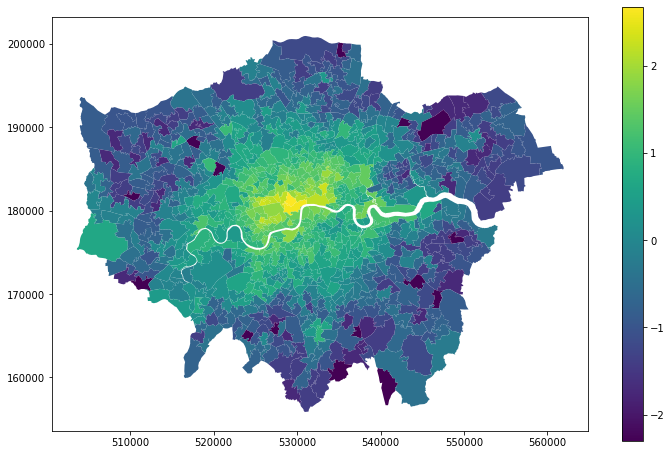

In [28]:
pnm = pd.merge(msoas.set_index('MSOA11CD'), pivot_norm, left_index=True, right_index=True)
pnm.plot(column='Entire home/apt', cmap='viridis', edgecolor='none', legend=True, figsize=(12,8));

### Task 3.4: PCA

<div class="alert alert-block alert-warning">
    <b>Difficulty level</b>: Moderate, though you might find the questions hard.
</div>

You can merge the output of this next step back on to the `rddf` data frame as part of a clustering process, though we'd really want to do some more thinking about what this data *means* and what transformations we'd need to do in order to make them *meaningful*. 

For instance, if we went back to last week's code, we could have appended this InsideAirbnb data *before* doing the dimensionality reduction, or we could apply it now to create a new measure that could be used as a separate part of the clustering process together with the reduced dimensionality of the demographic data. 

#### 3.4.1 Perform Reduction

In [29]:
pcomp = PCA(n_components=2, random_state=42)
rd    = pcomp.fit_transform(pivot_norm)
print(f"The explained variance of each component is: {', '.join([f'{x*100:.2f}%' for x in pcomp.explained_variance_ratio_])}")


The explained variance of each component is: 92.36%, 7.64%


Take the first component and convert to a series to enable the merge:

In [30]:
airbnb_pca = pd.DataFrame(
                {'Airbnb Component 1': mms.fit_transform(rd[:,1].reshape(-1,1)).reshape(1,-1)[0]}, 
                index=pivot.index)

airbnb_pca.head()

,Airbnb Component 1
MSOA11CD,
E02000001,0.40
E02000002,-0.39
E02000003,-0.17
E02000004,-0.40
E02000005,-0.57


You should have something like:
|       | Airbnb Component 1 |
| :---- | ----: |
| **MSOA11CD** |     |
| **E02000001** | 0.40 |
| **E02000002** | -0.39 

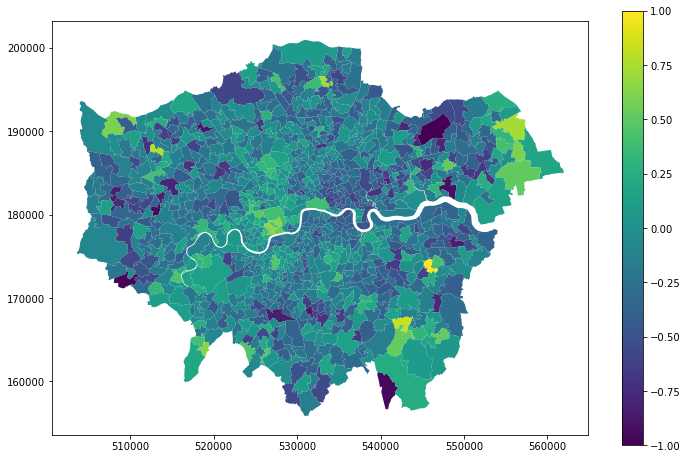

In [31]:
pcanm = pd.merge(msoas.set_index('MSOA11CD'), airbnb_pca, left_index=True, right_index=True)
pcanm.plot(column='Airbnb Component 1', cmap='viridis', edgecolor='none', legend=True, figsize=(12,8));

#### 3.4.2 Write to Data Frame

In [32]:
# Result Set from merge
rs = pd.merge(rddf, airbnb_pca, left_index=True, right_index=True)

Grab the PCA, UMAP, and Airbnb outputs for clustering and append rescaled price:

In [33]:
# Merge the reducded dimensionality data frame with the PCA-reduced Airbnb data
# to create the *cl*uster *d*ata *f*rame
cldf = pd.merge(rddf.loc[:,'Component 1':], airbnb_pca, 
                left_index=True, right_index=True)

# Append median price from cleaned listings grouped by MSOA too!
s1 = cleaned.groupby(by='MSOA11CD').price.agg('median')
cldf['median_price'] = pd.Series(np.squeeze(mms.fit_transform(s1.values.reshape(-1,1))), index=s1.index)

# Append mean price from cleaned listings grouped by MSOA too!
s2 = cleaned.groupby(by='MSOA11CD').price.agg('mean')
cldf['mean_price'] = pd.Series(np.squeeze(mms.fit_transform(s2.values.reshape(-1,1))), index=s2.index)

cldf.drop(columns=['Subregion','Borough'], inplace=True)

cldf.head()

,Component 1,Component 2,Component 3,Component 4,Component 5,Component 6,Component 7,Dimension 1,Dimension 2,Airbnb Component 1,median_price,mean_price
E02000001,2.82,-0.68,-1.78,0.21,1.44,3.95,-1.52,7.63,2.20,0.40,-0.73,-0.61
E02000002,-1.20,0.28,0.06,-1.50,-0.28,0.89,0.26,2.59,7.01,-0.39,-0.95,-0.92
E02000003,-0.49,0.53,-0.74,0.47,-0.11,1.12,0.83,3.39,6.12,-0.17,-0.92,-0.87
E02000004,-0.88,1.22,-0.14,-0.89,0.37,-0.13,1.10,2.28,5.95,-0.40,-0.95,-0.94
E02000005,-1.01,0.51,-0.46,-0.42,-0.43,0.84,1.58,3.16,7.25,-0.57,-0.90,-0.88


#### 3.4.3 Questions

- Have a think about why you might want to keep the Airbnb data separate from the MSOA data when doing PCA (or any other kind of dimensionality reduction)!

> This is very much a judgement call, but intuitively we are considering MSOA data (derived from the Census) as something very different from dynamically scraped Airbnb listings (from InsideAirbnb). So if we folded it all into one dimensionality reduction process we'd lose the ability to see that, for instance, some areas with high housing values and a particular demographic mix, have lots of Airbnb listings, while others do not. So if we're thinking in terms of prediction/regression keeping these separate gives us a little more flexibility.

- Why *might* it be interesting to add *both* mean and median MSOA prices to the clustering process? Here's a hint (but it's *very* subtle): `sns.jointplot(x=s1, y=s2, s=15, alpha=0.6)`

> Again, this is fairly rough-and-ready as an approach, but if we have a big difference between the normalised mean and median prices then this tells us something about the MSOA in terms of the distribution of listing prices within the area. Perhaps a *better* way would be to use the 25th and 75th percentiles, but this is a matter of **judgement**.

## Task 4. First K-Means Clustering

### Task 4.1: Perform Clustering

<div class="alert alert-block alert-success">
    <b>Difficulty level</b>: Low.
</div>

In [34]:
c_nm   = 'KMeans' # Clustering name
k_pref = 3 # Number of clusters

kmeans = KMeans(n_clusters=k_pref, n_init=25, random_state=42).fit(cldf.drop(columns=['Dimension 1','Dimension 2'])) # The process

Here are the results:

In [35]:
print(kmeans.labels_) # The results

[0 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 2 1 2 2 1 2
 1 1 2 2 2 2 2 0 2 2 2 2 1 0 2 2 2 1 2 0 2 2 0 2 2 2 2 2 1 2 1 1 1 2 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 1 2 2 2 1 2 2 2 2 2 2 2 2 2 0 2 2 2
 0 0 2 2 2 2 0 2 0 2 0 0 0 1 1 1 0 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 1 0 1 2 1 1 0 2 1 2 1 1 1 1 1
 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 0 0 2 2 2 2 0 2 0 2 2
 0 0 0 2 0 0 2 2 0 2 2 2 1 2 2 2 1 1 1 1 2 1 2 1 2 1 2 1 1 1 1 2 2 2 2 2 1
 0 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 0 2 0 1 2 1 0 1 1 1 1 1 1 1 1 1 2 2 2
 2 0 0 0 0 0 0 0 2 0 0 0 0 0 2 0 0 0 0 0 0 0 0 2 2 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 0 2 0 2 2 2 2 0 2 0 0 2 2 0 0 0 0 2 2 2 0
 0 2 0 0 2 0 0 0 0 1 1 1 1 1 1 2 2 1 2 2 2 2 1 1 2 1 2 2 1 2 2 1 2 2 2 2 2
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 2 

### Task 4.2: Save Clusters to Data Frame

<div class="alert alert-block alert-success">
    <b>Difficulty level</b>: Low.
</div>

#### 4.2.1 Write Series and Assign

Now capture the labels (i.e. clusters) and write them to a data series that we store on the result set df (`rs`):

In [36]:
rs[c_nm] = pd.Series(kmeans.labels_, index=cldf.index)

#### 4.2.2 Histogram of Cluster Members

How are the clusters distributed?

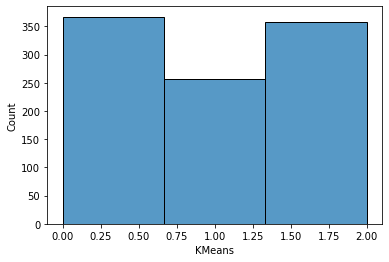

In [37]:
sns.histplot(data=rs, x=c_nm, bins=k_pref);

#### 4.2.3 Map Clusters

And here's a map!

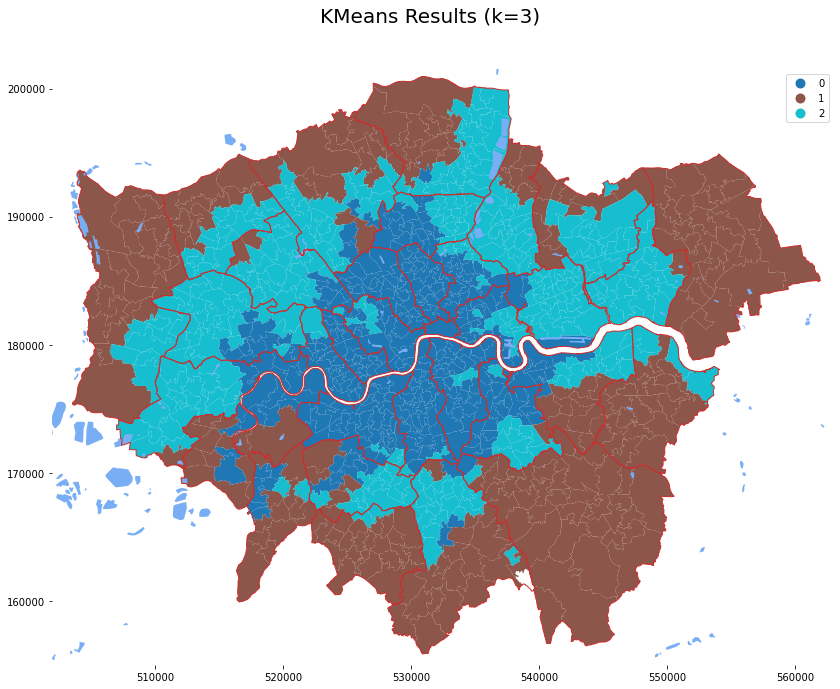

In [38]:
fig, ax = plt_ldn(water, boros)
fig.suptitle(f"{c_nm} Results (k={k_pref})", fontsize=20, y=0.92)
rs.plot(column=c_nm, ax=ax, linewidth=0, zorder=0, categorical=True, legend=True);

#### 4.2.4 Questions

- What critical assumption did we make when running this analysis?

> That 3 was somehow a meaningful number of clusters! I mean, it's interesting that we picked up a clear geography using the available PCA components, but why three? Why not 9? Or 7? 

- Why did I *not* use the UMAP dimensions here?

> Because they have a structure that is *clearly* incompatible with k-Means. Remember the sklearn clustering examples [here](https://scikit-learn.org/stable/modules/clustering.html#overview-of-clustering-methods). The way UMAP extracts structure just isn't compatible with that kind of clustering.

- Why do we have the `c_nm='kMeans'` when we *know* what kind of clustering we're doing?

> We'll use this 'cluster name' throughout the code to parameterise the output; it means that we can easily adapt our code to use a *different* clustering approach and know that wherever we want to name the clustering algorithm used it will be correct.

- Does this look like a *good* clustering?

> Yes and no. There is clearly a structure being extracted here because we can see it in the map, but the clusters are *very* unbalanced and, in some cases, that might be considered a relatively poor result. I would want to run some informal sensitivity tests to see how much of an impact the two pricing components are having on the results. Maybe we'd only want one pricing component? Or maybe something else is creating this structure?

## Task 5. Second K-Means Clustering

### Task 5.1: What's the 'Right' Number of Clusters?

<div class="alert alert-block alert-warning">
    <b>Difficulty level</b>: Moderate.
</div>

There's more than one way to find the 'right' number of clusters. In Singleton's _Geocomputation_ chapter they use WCSS to pick the 'optimal' number of clusters. The idea is that you plot the average WCSS for each number of possible clusters in the range of interest (2...n) and then look for a 'knee' (i.e. kink) in the curve. The principle of this approach is that you look for the point where there is declining benefit from adding more clusters. The problem is that there is always some benefit to adding more clusters (the perfect clustering is k==n), so you don't always see a knee.

Another way to try to make the process of selecting the number of clusters a little less arbitrary is called the silhouette plot and (like WCSS) it allows us to evaluate the 'quality' of the clustering outcome by examining the distance between each observation and the rest of the cluster. In this case it's based on Partitioning Around the Medoid (PAM).

Either way, to evaluate this in a systematic way, we want to do multiple k-means clusterings for multiple values of k and then we can look at which gives the best results...

In [39]:
kcldf = cldf.drop(columns=['Dimension 1','Dimension 2'])

#### 5.1.1 Repeated Clustering

Let's try clustering across a wider range.

In [40]:
# Adapted from: http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

x = []
y = []

# For resolutions of 'k' in the range 2..40
for k in range(2,41):
    
    #############
    # Do the clustering using the main columns
    kmeans = KMeans(n_clusters=k, n_init=25, random_state=42).fit(kcldf)
    
    # Calculate the overall silhouette score
    silhouette_avg = silhouette_score(kcldf, kmeans.labels_)
    
    y.append(k)
    x.append(silhouette_avg)
    
    print('.', end='')

.......................................

#### 5.1.2 Plot Silhouette Scores


Largest silhouette score was 0.2252 for k=8


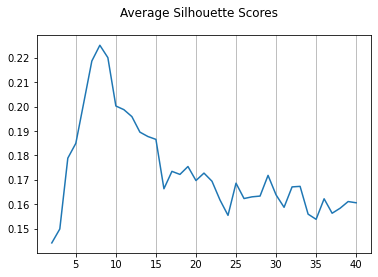

In [41]:
print()
print(f"Largest silhouette score was {max(x):6.4f} for k={y[x.index(max(x))]}")

plt.plot(y, x)
plt.gca().xaxis.grid(True);
plt.gcf().suptitle("Average Silhouette Scores");

<div class="alert alert-block alert-warning">
    <b>&#9888; Note</b>: Had we used the UMAP dimensions here you'd likely see more instability in the silhouette plot because the distribution is not remotely Gaussian, though a lot depends on the magnitude of the columns and the number of UMAP vs. PCA components.
</div>

We can use the largest average silhouette score to determine the 'natural' number of clusters in the data, but that that's only if we don't have any kind of underlying theory, other empirical evidence, or even just a reason for choosing a different value... Again, we're now getting in areas where your judgement and your ability to communicate your rationale to readers is the key thing.

### Task 5.2: Final Clustering 

<div class="alert alert-block alert-success">
    <b>Difficulty level</b>: Low.
</div>

So although we should probably pick the largest silhouette scores, that's `k=3` which kind of defeats the purpose of clustering in the first place. In the absence of a _compelling_ reason to pick 2 or 3 clusters, let's have a closer look at the _next_ maximum silhouetted score:

#### 5.2.1 Perform Clustering

In [42]:
k_pref=8

#############
# Do the clustering using the main columns
kmeans = KMeans(n_clusters=k_pref, n_init=25, random_state=42).fit(kcldf)

# Convert to a series
s = pd.Series(kmeans.labels_, index=kcldf.index, name=c_nm)

# We do this for plotting
rs[c_nm] = s
    
# Calculate the overall silhouette score
silhouette_avg = silhouette_score(kcldf, kmeans.labels_)

# Calculate the silhouette values
sample_silhouette_values = silhouette_samples(kcldf, kmeans.labels_)

#### 5.2.2 Plot Diagnostics

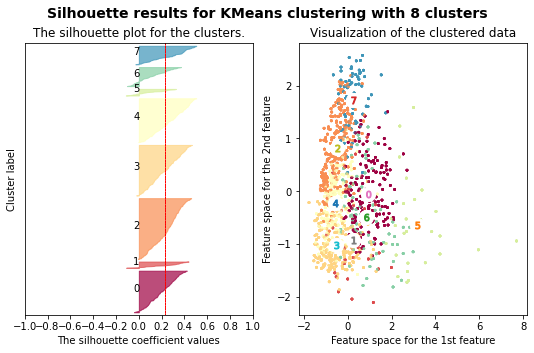

In [43]:
#############
# Create a subplot with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(9, 5)

# The 1st subplot is the silhouette plot
# The silhouette coefficient can range from -1, 1
ax1.set_xlim([-1.0, 1.0]) # Changed from -0.1, 1
    
# The (n_clusters+1)*10 is for inserting blank space between silhouette
# plots of individual clusters, to demarcate them clearly.
ax1.set_ylim([0, kcldf.shape[0] + (k_pref + 1) * 10])
    
y_lower = 10
    
# For each of the clusters...
for i in range(k_pref):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = \
        sample_silhouette_values[kmeans.labels_ == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
        
    # Set the color ramp
    color = plt.cm.Spectral(i/k_pref)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                        0, ith_cluster_silhouette_values,
                        facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--", linewidth=0.5)

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks(np.arange(-1.0, 1.1, 0.2)) # Was: [-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1]

    # 2nd Plot showing the actual clusters formed --
    # we can only do this for the first two dimensions
    # so we may not see fully what is causing the 
    # resulting assignment
    colors = plt.cm.Spectral(kmeans.labels_.astype(float) / k_pref)
    ax2.scatter(kcldf[kcldf.columns[0]], kcldf[kcldf.columns[1]], 
                marker='.', s=30, lw=0, alpha=0.7, c=colors)

    # Labeling the clusters
    centers = kmeans.cluster_centers_
    
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("Visualization of the clustered data")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

plt.suptitle(("Silhouette results for KMeans clustering "
                "with %d clusters" % k_pref),
                fontsize=14, fontweight='bold')

plt.show()

<div class="alert alert-block alert-warning">
    <b>&#9888; Stop</b>: Make sure that you understand how the silhouette plot and value work, and why your results <em>may</em> diverge from mine.
</div> 

#### 5.2.3 Map Clusters

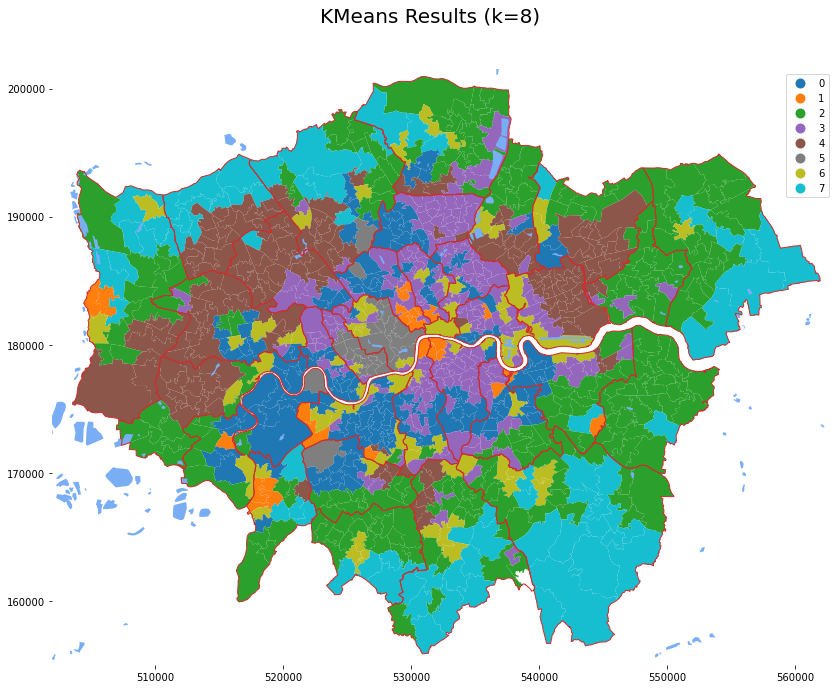

In [44]:
fig, ax = plt_ldn(water, boros)
fig.suptitle(f"{c_nm} Results (k={k_pref})", fontsize=20, y=0.92)
rs.plot(column=c_nm, ax=ax, linewidth=0, zorder=0, categorical=True, legend=True);

### Task 5.3: 'Representative' Centroids

<div class="alert alert-block alert-warning">
    <b>Difficulty level</b>: Moderate since, conceptually, there's a lot going on.
</div>

To get a sense of how these clusters differ we can try to extract 'representative' centroids (mid-points of the multi-dimensional cloud that constitutes a cluster). In the case of k-means this will work quite will since the clusters are explicitly built around mean centroids. There's also a k-medoids clustering approach built around the median centroid.

These are columns that we want to suppress from our sample:

In [45]:
to_suppress=['OBJECTID', 'BNG_E', 'BNG_N', 'LONG', 'LAT', 
             'Shape__Are', 'Shape__Len', 'geometry', 'Component 1', 
             'Component 2', 'Component 3', 'Component 4', 'Component 5', 
             'Component 6', 'Component 7', 'Dimension 1', 'Dimension 2', 
             'Airbnb Component 1']

Take a sample of the full range of numeric columns:

In [46]:
cols = random.sample(rs.select_dtypes(exclude='object').drop(columns=to_suppress).columns.to_list(), 12)
print(cols)

['Black/African/Caribbean/Black British', 'Age-45-64', 'Median-2008', 'Population Density-Persons per hectare (2012)', 'Semi-detached', 'Country of Birth-United Kingdom', 'Asian/Asian British', 'White', 'Qualifications-Level 3', 'Age-65+', 'Age-16-29', 'Age-Working-age']


Calculate the mean of these columns for each cluster:

In [47]:
# Empty data frame with the columns we'll need
centroids = pd.DataFrame(columns=cols)

# For each cluster...
for k in sorted(rs[c_nm].unique()):
    print(f"Processing cluster {k}")
    
    # Select rows where the cluster name matches the cluster number
    clust = rs[rs[c_nm]==k]
    
    # Append the means to the centroids data frame
    centroids.loc[k] = clust[cols].mean()

Processing cluster 0
Processing cluster 1
Processing cluster 2
Processing cluster 3
Processing cluster 4
Processing cluster 5
Processing cluster 6
Processing cluster 7


In [48]:
centroids

,Black/African/Caribbean/Black British,Age-45-64,Median-2008,Population Density-Persons per hectare (2012),Semi-detached,Country of Birth-United Kingdom,Asian/Asian British,White,Qualifications-Level 3,Age-65+,Age-16-29,Age-Working-age
0,-0.05,-0.04,0.56,0.17,-0.07,0.09,-0.06,0.21,-0.12,-0.04,0.05,0.32
1,0.03,-0.41,0.26,0.24,-0.15,-0.04,0.16,0.00,2.74,-0.20,1.08,0.66
2,0.07,0.30,-0.07,-0.17,0.42,0.37,-0.02,0.15,0.18,0.29,-0.20,-0.23
3,0.55,-0.21,0.03,0.42,-0.23,-0.14,0.06,-0.24,-0.06,-0.19,0.28,0.16
4,0.13,-0.07,0.02,0.09,0.26,-0.36,0.80,-0.52,-0.10,-0.04,0.19,0.03
5,-0.26,0.16,2.10,0.19,-0.24,-0.40,-0.00,0.20,0.17,0.27,0.06,0.32
6,0.01,-0.24,0.26,0.19,-0.16,-0.08,0.11,0.03,0.02,-0.06,0.31,0.42
7,-0.24,0.65,0.39,-0.37,0.53,0.43,0.08,0.26,0.36,0.86,-0.39,-0.41


In [49]:
centroids_long = pd.DataFrame(columns=['Variable','Cluster','Std. Value'])
for i in range(0,len(centroids.index)):
    row = centroids.iloc[i,:]
    for r in row.index:
        d = pd.DataFrame({'Variable':r, 'Cluster':i, 'Std. Value':row[r]}, index=[1])
        centroids_long = pd.concat([centroids_long, d], ignore_index=True)

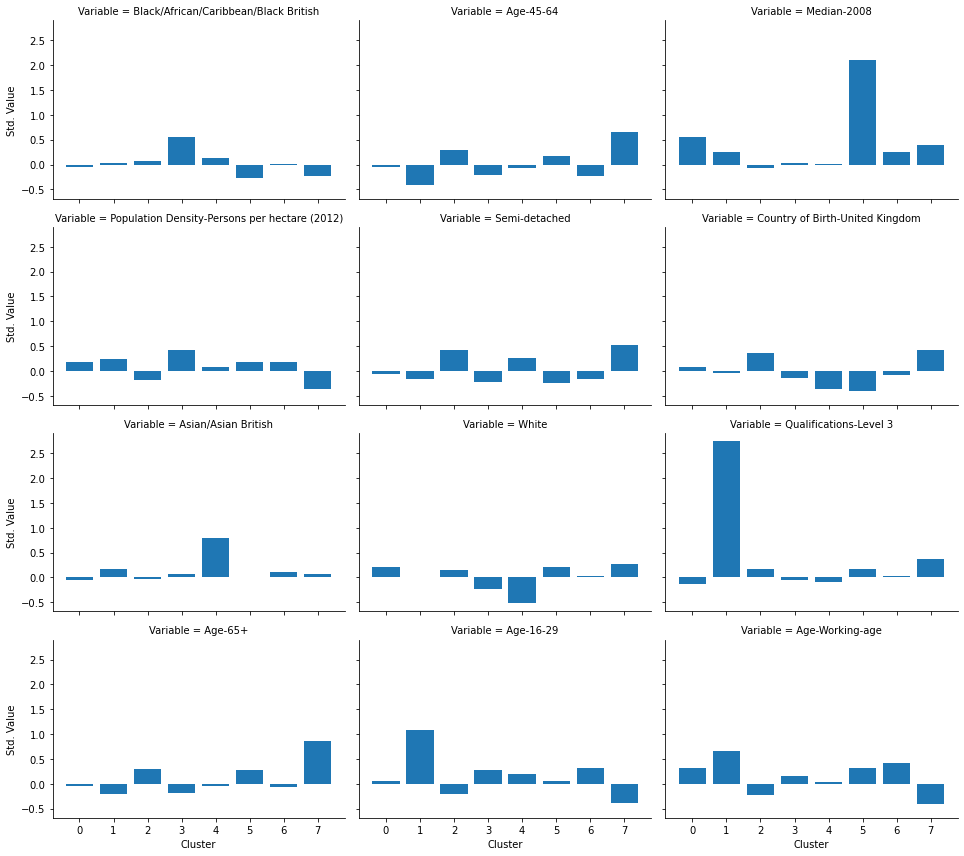

In [50]:
g = sns.FacetGrid(centroids_long, col="Variable", col_wrap=3, height=3, aspect=1.5, margin_titles=True, sharey=True)
g = g.map(plt.bar, "Cluster", "Std. Value")

## Task 6. DBSCAN

For what it's worth, I've had _enormous_ trouble with DBSCAN and this kind of data. I don't think it deals very well with more than three dimensions, so the flexbility to not have to specify the number of clusters is balanced with a density-based approach that is severely hampered by high-dimensional distance-inflation.

In [51]:
# Drop the PCA dimensions
cldf2 = cldf.loc[:,'Dimension 1':].copy()
for c in [x for x in cldf.columns.to_list() if x.startswith('Dimension ')]:
    cldf2[c] = pd.Series(np.squeeze(mms.fit_transform(cldf2[c].to_numpy().reshape(-1,1))), index=cldf2.index)
cldf2.head()

,Dimension 1,Dimension 2,Airbnb Component 1,median_price,mean_price
E02000001,0.73,-0.91,0.40,-0.73,-0.61
E02000002,-0.69,0.31,-0.39,-0.95,-0.92
E02000003,-0.46,0.08,-0.17,-0.92,-0.87
E02000004,-0.78,0.04,-0.40,-0.95,-0.94
E02000005,-0.53,0.37,-0.57,-0.90,-0.88


### Task 6.1: Work out the Neighbour Distance

<div class="alert alert-block alert-warning">
    <b>Difficulty level</b>: Moderate.
</div>

We normally look for some kind of 'knee' to set the distance.

In [52]:
nbrs = NearestNeighbors(n_neighbors=6).fit(cldf2)
distances, indices = nbrs.kneighbors(cldf2)

distances = np.sort(distances, axis=0)
distances = distances[:,1]

### Task 6.2: Derive Approximate Knee

<div class="alert alert-block alert-success">
    <b>Difficulty level</b>: Low.
</div>


Knee detected at: 904


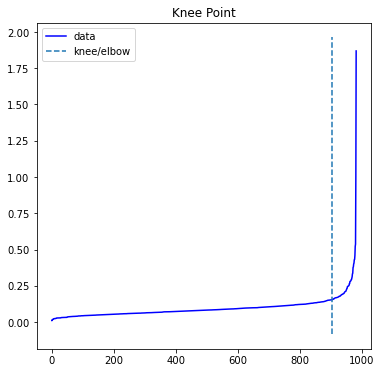

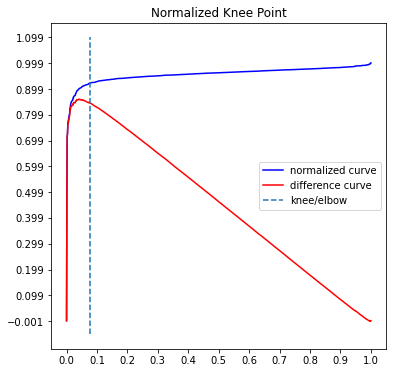

In [53]:
from kneed import knee_locator

kn = knee_locator.KneeLocator(np.arange(distances.shape[0]), distances, S=12,
                              curve='convex', direction='increasing')
print(f"Knee detected at: {kn.knee}")
kn.plot_knee()
kn.plot_knee_normalized()

In [54]:
print(f"Best guess at epsilon for DBSCAN is {distances[kn.knee]:0.4f}")

Best guess at epsilon for DBSCAN is 0.1551


### Task 6.3: Explore Epsilons

<div class="alert alert-block alert-warning">
    <b>Difficulty level</b>: Moderate.
</div>

There are two values that need to be specified: `eps` and `min_samples`. Both seem to be set largely by trial and error, though we can use the above result as a target. It's easiest to set `min_samples` first since that sets a floor for your cluster size and then `eps` is basically a distance metric that governs how far away something can be from a cluster and still be considered part of that cluster.

#### 6.3.1 Iterate Over Range

<div class="alert alert-block alert-danger">
    <b>&#9888; Warning</b>: Depending on the data volume, this next step may take quite a lot of time since we are iterating through many, many values of Epsilon to explore how the clustering result changes and how well this matches up with (or doesn't) the graph above.
</div>

In [55]:
c_nm = 'DBSCAN'

# Make numeric display a bit neater
pd.set_option('display.float_format', lambda x: '{:,.4f}'.format(x))

el  = []

max_clusters  = 10
cluster_count = 1

iters = 0

for e in np.arange(0.025, 0.76, 0.01): # <- You might want to adjust these!
    
    if iters % 25==0: print(f"{iters} epsilons explored.") 
    
    # Run the clustering
    dbs = DBSCAN(eps=e, min_samples=cldf2.shape[1]+1).fit(cldf2)
    
    # See how we did
    s = pd.Series(dbs.labels_, index=cldf2.index, name=c_nm)
    
    row = [e]
    data = s.value_counts()
    
    for c in range(-1, max_clusters+1):
        try:
            if np.isnan(data[c]):
                row.append(None)
            else: 
                row.append(data[c])
        except KeyError:
            row.append(None)
    
    el.append(row)
    iters+=1

edf = pd.DataFrame(el, columns=['Epsilon']+["Cluster " + str(x) for x in list(range(-1,max_clusters+1))])

# Make numeric display a bit neater
pd.set_option('display.float_format', lambda x: '{:,.2f}'.format(x))

print("Done.")

0 epsilons explored.
25 epsilons explored.
50 epsilons explored.
Done.


#### 6.3.2 Examine Clusters

In [56]:
edf.head() # Notice the -1 cluster for small epsilons

,Epsilon,Cluster -1,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5,Cluster 6,Cluster 7,Cluster 8,Cluster 9,Cluster 10
0,0.03,982,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.04,982,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.05,982,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.06,976,6.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.07,972,10.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [57]:
epsilon_long = pd.DataFrame(columns=['Epsilon','Cluster','Count'])

for i in range(0,len(edf.index)):
    row = edf.iloc[i,:]
    for c in range(1,len(edf.columns.values)):
        if row[c] != None and not np.isnan(row[c]):
            d = pd.DataFrame({'Epsilon':row[0], 'Cluster':f"Cluster {c-2}", 'Count':row[c]}, index=[1])
            epsilon_long = pd.concat([epsilon_long, d], ignore_index=True)

epsilon_long['Count'] = epsilon_long.Count.astype(float)

#### 6.3.3 Plot Cluster Sizes

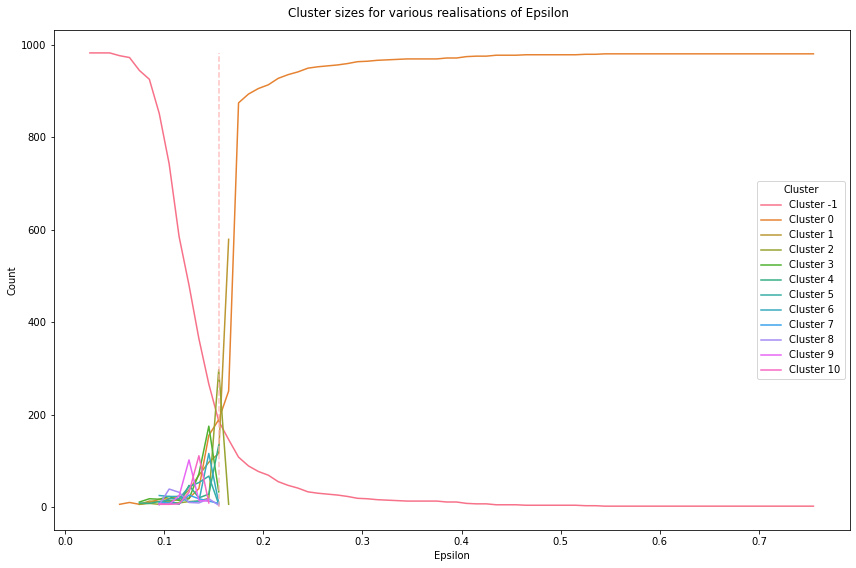

In [58]:
fig, ax = plt.subplots(figsize=(12,8))
sns.lineplot(data=epsilon_long, x='Epsilon', y='Count', hue='Cluster');
plt.vlines(x=distances[kn.knee], ymin=0, ymax=epsilon_long.Count.max(), color=(1, .7, .7, .8), linestyles='dashed')
plt.gcf().suptitle(f"Cluster sizes for various realisations of Epsilon");
plt.tight_layout()

### Task 6.4: Final Clustering

<div class="alert alert-block alert-warning">
    <b>Difficulty level</b>: Moderate.
</div>

#### 6.4.1: Perform Clustering

Use the value from kneed...

In [59]:
dbs = DBSCAN(eps=distances[kn.knee], min_samples=cldf2.shape[1]+1).fit(cldf2.values)
s = pd.Series(dbs.labels_, index=cldf2.index, name=c_nm)
rs[c_nm] = s
print(s.value_counts())

 2    297
 0    190
-1    185
 4    134
 1    116
 3     33
 6      9
 7      8
 5      6
 8      4
Name: DBSCAN, dtype: int64


#### 6.4.2: Map Clusters

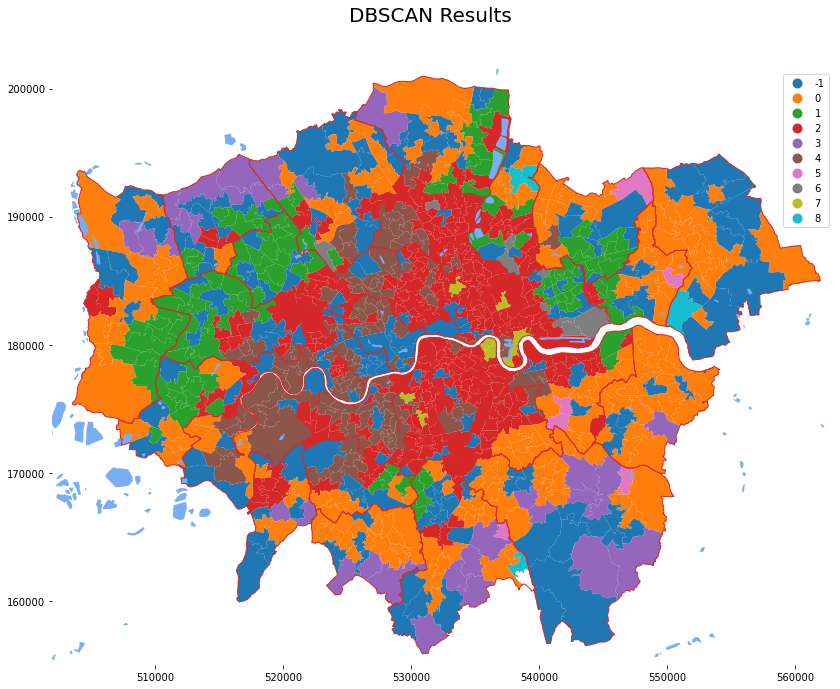

In [60]:
fig, ax = plt_ldn(water, boros)
fig.suptitle(f"{c_nm} Results", fontsize=20, y=0.92)
rs.plot(column=c_nm, ax=ax, linewidth=0, zorder=0, legend=True, categorical=True);

#### 6.4.3 'Representative' Centroids

In [61]:
to_suppress=['OBJECTID', 'BNG_E', 'BNG_N', 'LONG', 'LAT', 
             'Shape__Are', 'Shape__Len', 'geometry', 'Component 1', 
             'Component 2', 'Component 3', 'Component 4', 'Component 5', 
             'Component 6', 'Component 7', 'Dimension 1', 'Dimension 2', 
             'Airbnb Component 1']

Take a sample of the full range of numeric columns:

In [62]:
cols = random.sample(rs.select_dtypes(exclude='object').drop(columns=to_suppress).columns.to_list(), 12)
print(cols)

['Detached', 'Terraced (including end-terrace)', 'Total Median hh Income', 'Age-45-64', 'Household spaces with at least one usual resident', 'Qualifications-Apprenticeship', 'Semi-detached', 'Qualifications-Schoolchildren and full-time students: Age 18 and over', 'Median-2008', 'Age-0-15', 'Language-None have English as main language', 'Sales-2008']


Calculate the mean of these columns for each cluster:

In [63]:
# Empty data frame with the columns we'll need
centroids = pd.DataFrame(columns=cols)

# For each cluster...
for k in sorted(rs[c_nm].unique()):
    print(f"Processing cluster {k}")
    
    # Select rows where the cluster name matches the cluster number
    clust = rs[rs[c_nm]==k]
    
    # Append the means to the centroids data frame
    centroids.loc[k] = clust[cols].mean()

Processing cluster -1
Processing cluster 0
Processing cluster 1
Processing cluster 2
Processing cluster 3
Processing cluster 4
Processing cluster 5
Processing cluster 6
Processing cluster 7
Processing cluster 8


In [64]:
# Drop the unclustered records (-1)
centroids.drop(labels=[-1], axis=0, inplace=True)
centroids

,Detached,Terraced (including end-terrace),Total Median hh Income,Age-45-64,Household spaces with at least one usual resident,Qualifications-Apprenticeship,Semi-detached,Qualifications-Schoolchildren and full-time students: Age 18 and over,Median-2008,Age-0-15,Language-None have English as main language,Sales-2008
0,0.25,0.25,0.05,0.32,0.05,0.60,0.41,-0.22,-0.04,0.11,-0.28,0.19
1,0.17,0.32,-0.17,-0.03,-0.12,0.04,0.30,0.25,-0.03,0.27,0.51,-0.03
2,-0.07,-0.08,-0.08,-0.23,0.14,-0.07,-0.17,0.41,0.05,0.00,0.18,-0.01
3,1.96,-0.31,0.50,0.66,-0.20,0.57,0.57,-0.29,0.41,-0.09,-0.35,-0.00
4,-0.02,-0.02,0.66,-0.03,0.18,-0.16,-0.11,-0.05,0.81,-0.30,-0.06,0.23
5,0.09,0.25,-0.18,0.24,-0.24,0.48,0.50,-0.22,-0.10,0.36,-0.27,-0.23
6,0.19,0.32,-0.22,-0.28,-0.27,-0.09,0.00,0.55,-0.09,0.22,0.55,-0.25
7,-0.18,-0.13,0.49,-0.59,0.73,-0.13,-0.24,0.25,0.26,-0.54,0.11,1.01
8,0.16,0.13,-0.14,0.39,-0.02,0.81,0.64,-0.31,-0.12,0.20,-0.39,-0.03


In [65]:
centroids_long = pd.DataFrame(columns=['Variable','Cluster','Std. Value'])
for i in range(0,len(centroids.index)):
    row = centroids.iloc[i,:]
    for r in row.index:
        d = pd.DataFrame({'Variable':r, 'Cluster':i, 'Std. Value':row[r]}, index=[1])
        centroids_long = pd.concat([centroids_long, d], ignore_index=True)

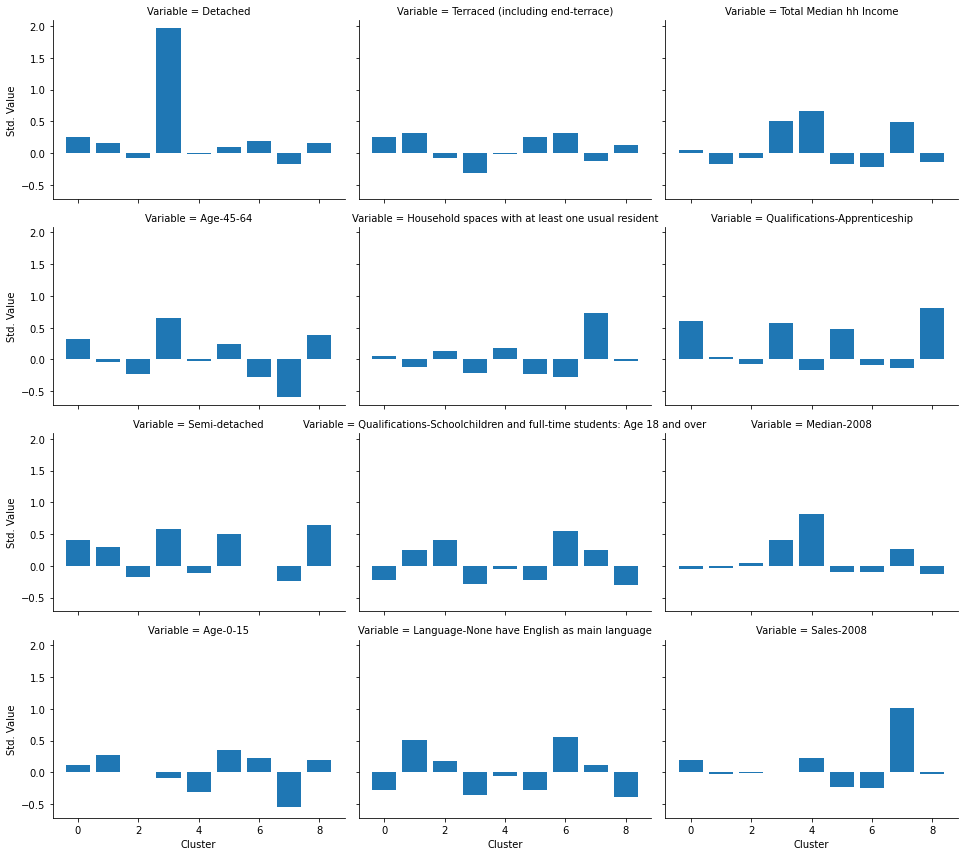

In [66]:
g = sns.FacetGrid(centroids_long, col="Variable", col_wrap=3, height=3, aspect=1.5, margin_titles=True, sharey=True)
g = g.map(plt.bar, "Cluster", "Std. Value")

## Task 7. Self-Organising Maps

SOMs offer a third type of clustering algorithm. They are a relatively 'simple' type of neural network in which the 'map' (of the SOM) adjusts to the data. We're not going to do this in *this* practical, but the main thing is that, unlike the above approaches, SOMs build a 2D map of a higher-dimensional space and use this as a mechanism for subsequently clustering the raw data. In this sense there is a conceptual link between SOMs and PCA or t-SNE or UMAP. Tehy are used quite a lot for text-clustering using keywords (where you have high-dimensionality).

There are [a lot of SOM implementations in Python](https://www.google.com/search?q=python+self-organizing+map) but the one I used to use, called SOMPY, appears to have [been abandonned](https://github.com/sevamoo/SOMPY/issues).

## Task 8. Classification

And now for something completely different! This is section is **completely optional**, but I thought that you might find it helpful to have a look at how *supervised* learning (classification) differs from *unsupervised* learning (clustering). Here we're going to perform a fairly straightforward classification: predicting the `room_type` for randomly-selected listings. Of course we know the true answer, but this is for demonstration purposes!

### Task 8.1: Additional Setup

<div class="alert alert-block alert-danger">
    <b>Difficulty level</b>: Hard, as I've left out quite a bit of code.
</div>

#### 8.1.1 Import Libraries

In [67]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.inspection import permutation_importance

#### 8.1.2 Set Up Data

I'm taking a fairly brutal approach here: anything that is not inherently numeric is gone (bye, bye, text), and I'm not bothering to convert implicitly numeric values either: dates could be converted to 'months since last review', for instance, while amenities could be One-Hot Encoded after some pruning of rare amenities. This leaves us with a much smaller number of columns to feed *in* to the classifier.

In [68]:
print(f"Cleaned columns: {', '.join(cleaned.columns.to_list())}.")
classifier_in = cleaned.drop(columns=['listing_url','last_scraped','name','description',
                                      'host_name', 'host_location', 'property_type', 
                                      'bathrooms_text', 'amenities', 'geometry', 'MSOA11CD',
                                      'host_since', 'first_review', 'last_review',
                                      'host_verifications', 'review_scores_rating',
                                      'reviews_per_month'])

Cleaned columns: listing_url, last_scraped, name, description, host_id, host_name, host_since, host_location, host_is_superhost, host_listings_count, host_total_listings_count, host_verifications, property_type, room_type, accommodates, bathrooms_text, bedrooms, beds, amenities, price, minimum_nights, maximum_nights, availability_365, number_of_reviews, first_review, last_review, review_scores_rating, reviews_per_month, geometry, MSOA11CD.


#### 8.1.3 Remove NAs

Not all classifiers have this issue, but some will struggle to make predictions (or not be able to do so at all) if there are NAs in the data set. The classifier we're using can't deal with NAs, so we have to strip these out, but before we do let's check the effect:

In [69]:
classifier_in.isna().sum()

host_id                         0
host_is_superhost               0
host_listings_count             0
host_total_listings_count       0
room_type                       0
accommodates                    0
bedrooms                     3065
beds                          946
price                           0
minimum_nights                  0
maximum_nights                  0
availability_365                0
number_of_reviews               0
dtype: int64

We can safely drop these now, and you should end up with about 63,162 rows to work with.

In [70]:
classifier_in = classifier_in.dropna(axis=0, how='any')
print(f"Now have {classifier_in.shape[0]:,} rows of data to work with (down from {cleaned.shape[0]:,}).")

Now have 63,162 rows of data to work with (down from 67,087).


In [71]:
print()
print(f"Classifier training columns: {', '.join(classifier_in.columns.to_list())}.")
classifier_in.head()


Classifier training columns: host_id, host_is_superhost, host_listings_count, host_total_listings_count, room_type, accommodates, bedrooms, beds, price, minimum_nights, maximum_nights, availability_365, number_of_reviews.


,host_id,host_is_superhost,host_listings_count,host_total_listings_count,room_type,accommodates,bedrooms,beds,price,minimum_nights,maximum_nights,availability_365,number_of_reviews
id,,,,,,,,,,,,,
13913,54730,False,3,4,Private room,1,1.00,1,50.00,1,29,343,30.00
89870,54730,False,3,4,Entire home/apt,4,1.00,3,145.00,1,60,343,115.00
958304,5213743,False,1,1,Entire home/apt,2,1.00,1,110.00,5,21,0,4.00
993428,5457414,False,1,2,Private room,2,1.00,2,80.00,1,5,221,112.00
1211331,6614363,False,3,3,Private room,1,1.00,1,51.00,2,1125,314,96.00


#### 8.1.4 Remap Non-Numeric Columns

We do still have a couple of non-numeric columns to deal with: booleans and the thing we're actually trying to predict (the room type)!

In [72]:
classifier_in['host_is_superhost'] = classifier_in.host_is_superhost.replace({True:1, False:0}).astype('int')

In [73]:
le = LabelEncoder()
classifier_in['room_class'] = le.fit_transform(classifier_in.room_type)

A quick check: we should only have one type per class and vice versa.

In [74]:
classifier_in.groupby(by=['room_type','room_class']).host_id.agg('count').reset_index()

,room_type,room_class,host_id
0,Entire home/apt,0,37766
1,Entire home/apt,1,0
2,Entire home/apt,2,0
3,Entire home/apt,3,0
4,Hotel room,0,0
5,Hotel room,1,137
6,Hotel room,2,0
7,Hotel room,3,0
8,Private room,0,0
9,Private room,1,0


### Task 8.2: Random Forest Classification

<div class="alert alert-block alert-danger">
    <b>Difficulty level</b>: Hard.
</div>

We're going to use a [Random Forest Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) but the nice thing about `sklearn` is that you can quite easily swap in other classifiers if you'd like to explore further. This is one *big* advantage of Python over R in my book: whereas R tends to get new algorithms *first*, they are often implemented independently by many people and you can end up with incompatible data structures that require a lot of faff to reorganise for a different algorithm. Python is a bit more 'managed' and the dominance of `numpy` and `sklearn` and `pandas` means that people have an incentive to contribute to this library or, if it's genuinely novel, to create an implementation that works *like* it would if it were part of `sklearn`!

#### 8.2.1 Train/Test Split

In [75]:
train, test = train_test_split(classifier_in, test_size=0.2, random_state=42)
print(f"Train contains {train.shape[0]:,} records.")
print(f"Test contains {test.shape[0]:,} records.")

Train contains 50,529 records.
Test contains 12,633 records.


In [76]:
y_train = train.room_class
X_train = train.drop(columns=['room_class','room_type'])

y_test  = test.room_class
X_test  = test.drop(columns=['room_class','room_type'])

#### 8.2.2 Classifier Setup

In [77]:
rfc = RandomForestClassifier(
    max_depth=8,
    min_samples_split=7,
    n_jobs=4,
    random_state=42
)

#### 8.2.3 Fit and Predict

In [78]:
rfc.fit(X_train, y_train)

RandomForestClassifier(max_depth=8, min_samples_split=7, n_jobs=4,
                       random_state=42)

In [79]:
y_hat = rfc.predict(X_test)

### Task 8.3 Validate

<div class="alert alert-block alert-danger">
    <b>Difficulty level</b>: Hard.
</div>

#### 8.3.1 Confusion Matrix

In [80]:
c_matrix = pd.DataFrame(confusion_matrix(y_test, y_hat))
c_matrix.index = le.inverse_transform(c_matrix.index)
c_matrix.columns = le.inverse_transform(c_matrix.columns)
c_matrix

,Entire home/apt,Hotel room,Private room,Shared room
Entire home/apt,6981,0,509,0
Hotel room,19,0,16,1
Private room,755,0,4288,1
Shared room,8,0,48,7


#### 8.3.2 Feature Importance 

Compare the Random Forest's built-in 'feature importance' with Permutation Feature Importance as [documented here](https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html).

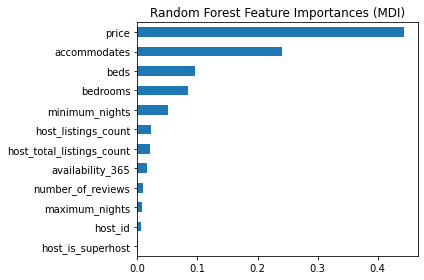

In [81]:
mdi_importances = pd.Series(
    rfc.feature_importances_, index=rfc.feature_names_in_
).sort_values(ascending=True)

ax = mdi_importances.plot.barh()
ax.set_title("Random Forest Feature Importances (MDI)")
ax.figure.tight_layout()

#### 8.3.3 Permutation Feature Importance

In [82]:
result = permutation_importance(
    rfc, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)

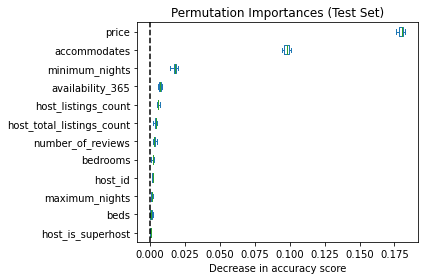

In [83]:
sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X_test.columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (Test Set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

### Task 8.4 Shapely Values

Shapely values are a big part of [explainable AI](https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html) and they work (very broadly) by permuting the data to explore how sensitive the predictions made by the model are to the results that you see. For these we need to install two libraries: `shap` (to do the heavy lifting) and `slicer` to deal with the data.

#### 8.4.1 Install Libraries

You could also wrap this in a `try... except` if you want to write reproducible code!

In [84]:
! pip install slicer shap

In [85]:
import shap

#### 8.4.2 Check for Data Types

You are looking for anything *other* than `int64` or `float64` for the most part. Boolean should be fine, but pandas' internal, nullable integer type will give you a `ufunc` error.

In [86]:
X_test.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12633 entries, 4003884 to 11473645
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   host_id                    12633 non-null  int64  
 1   host_is_superhost          12633 non-null  int64  
 2   host_listings_count        12633 non-null  int64  
 3   host_total_listings_count  12633 non-null  int64  
 4   accommodates               12633 non-null  int64  
 5   bedrooms                   12633 non-null  float64
 6   beds                       12633 non-null  UInt16 
 7   price                      12633 non-null  float64
 8   minimum_nights             12633 non-null  int64  
 9   maximum_nights             12633 non-null  int64  
 10  availability_365           12633 non-null  int64  
 11  number_of_reviews          12633 non-null  float64
dtypes: UInt16(1), float64(3), int64(8)
memory usage: 1.2 MB


In [87]:
X_test['beds'] = X_test.beds.astype('int')

#### 8.4.3 Plot Partial Dependence

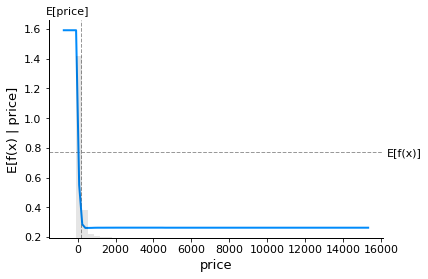

In [88]:
shap.partial_dependence_plot(
    "price", rfc.predict, X_test, ice=False,
    model_expected_value=True, feature_expected_value=True
)

#### 8.4.4 Calculate Shapely Values

This can take a *long* time: 4-5 hours (!!!) without developing a *strategy* for tackling it. See the [long discussion here](https://github.com/slundberg/shap/issues/77). I've taken the approach of subsetting the data substantially (the model is already trained so it won't impact the model's predictions) with a 20% fraction of the test data and an explainer sample of 5%. On my laptop the 'Permutation explainer' stage took about 14 minutes, but your results may obviously be rather different.

In [89]:
Xsample = shap.utils.sample(X_test.sample(frac=0.2, random_state=41), 10)
explainer = shap.Explainer(rfc.predict, Xsample)

Now we calculate the shap values for the 5% sample from `X_test`.

<div class="alert alert-block alert-danger">
    <b>&#9888; Warning</b>: This next block is the one that takes a long time to run.
</div>

In [90]:
shap_values = explainer(X_test.sample(frac=.05, random_state=42))

Permutation explainer: 633it [14:44,  1.41s/it]                         


#### 8.4.5 Single Observation

Now you can take any random record (`sample_ind`) and produce a shap plot to show the role that each attribute played in its classification. Note that getting these plots to save required [some searching on GitHub](https://github.com/slundberg/shap/issues/153).

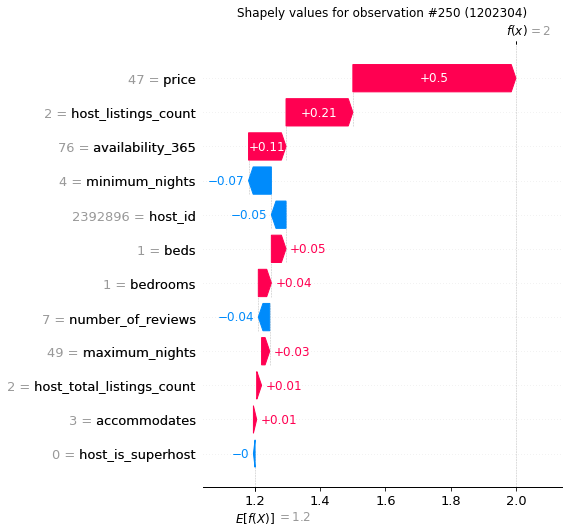

In [91]:
sample_ind=250
shap.plots.waterfall(shap_values[sample_ind], max_display=14, show=False);
plt.title(f"Shapely values for observation #{sample_ind} ({X_test.sample(frac=.05, random_state=42).iloc[sample_ind].name})")
plt.tight_layout()
plt.savefig('practical-09-waterfall.png', dpi=150)

![Shapely Feature Plot for Feature 250](https://github.com/jreades/fsds/raw/master/practicals/img/practical-09-waterfall.png)

#### 8.4.6 All Observations

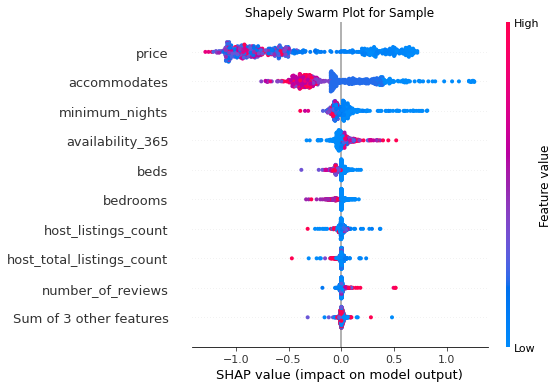

In [92]:
shap.plots.beeswarm(shap_values, show=False)
plt.title(f"Shapely Swarm Plot for Sample")
plt.tight_layout()
plt.savefig('practical-09-swarm.png', dpi=150)

![Shapely Swarm Plot](https://github.com/jreades/fsds/raw/master/practicals/img/practical-09-swarm.png)

## Wrap-Up

- Find the appropriate eps value: [Nearest Neighbour Distance Functions](https://nbviewer.jupyter.org/github/pysal/pointpats/blob/master/notebooks/distance_statistics.ipynb#Nearest-Neighbor-Distance-Functions) or [Interevent Distance Functions](https://nbviewer.jupyter.org/github/pysal/pointpats/blob/master/notebooks/distance_statistics.ipynb#Interevent-Distance-Functions)
- [Clustering Points](https://darribas.org/gds_course/content/bH/lab_H.html#clusters-of-points)
- [Regionalisation algorithms with Aglomerative Clustering](https://darribas.org/gds_course/content/bG/lab_G.html#regionalization-algorithms)


You've reached the end, you're done... 

Er, no. This is barely scratching the surface! I'd suggest that you go back through the above code and do three things:
1. Add a lot more comments to the code to ensure that really have understood what is going on.
2. Try playing with some of the parameters (e.g. my thresholds for skew, or non-normality) and seeing how your results change.
3. Try outputting additional plots that will help you to understand the _quality_ of your clustering results (e.g. what _is_ the makeup of cluster 1? Or 6? What has it picked up? What names would I give these clsuters?).

If all of that seems like a lot of work then why not learn a bit more about machine learning before calling it a day?

See: [Introduction to Machine Learning with Scikit-Learn](http://www.slideshare.net/BenjaminBengfort/introduction-to-machine-learning-with-scikitlearn).